In [1]:
%matplotlib inline

In [2]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM, RNN
from keras.initializers import RandomUniform
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
# import tensorflow as tf; tf.Session(config=tf.ConfigProto(log_device_placement=True))

import nengo
from lmu import LMUCell

Using TensorFlow backend.


In [3]:
import collections

def mackey_glass(sample_len=1000, tau=17, delta_t=10, seed=None, n_samples=1):
    # Adapted from https://github.com/mila-iqia/summerschool2015/blob/master/rnn_tutorial/synthetic.py
    '''
    mackey_glass(sample_len=1000, tau=17, seed = None, n_samples = 1) -> input
    Generate the Mackey Glass time-series. Parameters are:
        - sample_len: length of the time-series in timesteps. Default is 1000.
        - tau: delay of the MG - system. Commonly used values are tau=17 (mild 
          chaos) and tau=30 (moderate chaos). Default is 17.
        - seed: to seed the random generator, can be used to generate the same
          timeseries at each invocation.
        - n_samples : number of samples to generate
    '''
    history_len = tau * delta_t 
    # Initial conditions for the history of the system
    timeseries = 1.2
    
    if seed is not None:
        np.random.seed(seed)

    samples = []

    for _ in range(n_samples):
        history = collections.deque(1.2 * np.ones(history_len) + 0.2 * \
                                    (np.random.rand(history_len) - 0.5))
        # Preallocate the array for the time-series
        inp = np.zeros((sample_len,1))
        
        for timestep in range(sample_len):
            for _ in range(delta_t):
                xtau = history.popleft()
                history.append(timeseries)
                timeseries = history[-1] + (0.2 * xtau / (1.0 + xtau ** 10) - \
                             0.1 * history[-1]) / delta_t
            inp[timestep] = timeseries
        
        # Squash timeseries through tanh
        inp = np.tanh(inp - 1)
        samples.append(inp)
    return samples


def generate_data(n_batches, length, split=0.5, seed=0,
                  predict_length=15, tau=17, washout=100, delta_t=1,
                  center=True):
    X = np.asarray(mackey_glass(
        sample_len=length+predict_length+washout, tau=tau,
        seed=seed, n_samples=n_batches))
    X = X[:, washout:, :]
    cutoff = int(split*n_batches)
    if center:
        X -= np.mean(X)  # global mean over all batches, approx -0.066
    Y = X[:, :-predict_length, :]
    X = X[:, predict_length:, :]
    assert X.shape == Y.shape
    return ((X[:cutoff], Y[:cutoff]),
            (X[cutoff:], Y[cutoff:]))

In [4]:
(train_X, train_Y), (test_X, test_Y) = generate_data(128, 5000)
print(train_X.shape, test_X.shape)

(64, 5000, 1) (64, 5000, 1)


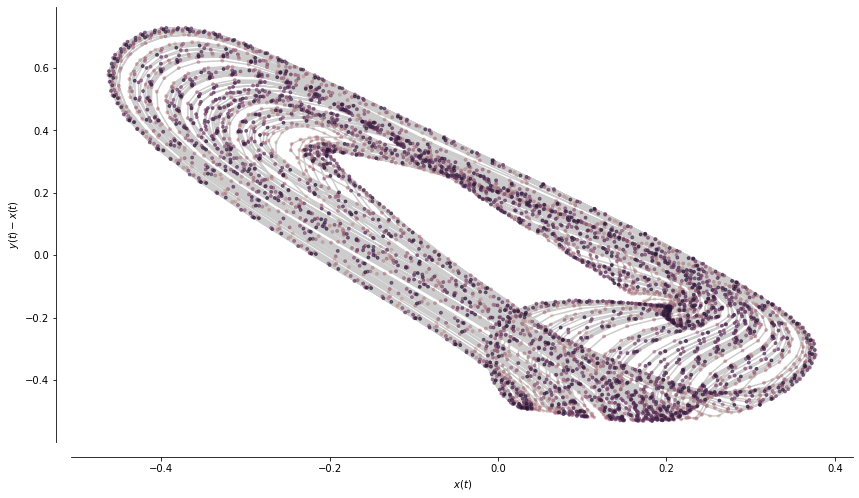

In [5]:
def cool_plot(X, Y, title=""):
    plt.figure(figsize=(14, 8))
    plt.title(title)
    plt.scatter(X[:, 0], Y[:, 0] - X[:, 0], s=8, alpha=0.7,
                c=np.arange(X.shape[0]), cmap=sns.cubehelix_palette(as_cmap=True))
    plt.plot(X[:, 0], Y[:, 0] - X[:, 0], c='black', alpha=0.2)
    plt.xlabel("$x(t)$")
    plt.ylabel("$y(t) - x(t)$")
    sns.despine(offset=15)
    
    plt.show()

cool_plot(train_X[0], train_Y[0])

In [11]:
def make_lstm(units, layers):
    model = Sequential()
    model.add(LSTM(units,
                   input_shape=(train_X.shape[1], 1),  # (timesteps, input_dims)
                   return_sequences=True))  # continuously outputs per timestep
    for _ in range(layers-1):
        model.add(LSTM(units, return_sequences=True))
    model.add(Dense(train_X.shape[-1], activation='tanh'))
    model.compile(loss="mse", optimizer="adam")
    model.summary()
    return model


def delay_layer(units, **kwargs):
    return RNN(LMUCell(units=units,
                       order=4,
                       theta=4,
                      ),
               return_sequences=True,
               **kwargs)


def make_lmu(units, layers):
    model = Sequential()
    model.add(delay_layer(units,
                          input_shape=(train_X.shape[1], 1)))  # (timesteps, input_dims)
    for _ in range(layers-1):
        model.add(delay_layer(units))
    model.add(Dense(train_X.shape[-1], activation='linear'))
    model.compile(loss="mse", optimizer="adam")
    model.summary()
    
    return model


def make_hybrid(units_lstm, units_lmu, layers):
    assert layers == 4, "unsupported"
    model = Sequential()
    model.add(delay_layer(units=units_lmu,input_shape=(train_X.shape[1], 1)))
    model.add(LSTM(units=units_lstm, return_sequences=True))
    model.add(delay_layer(units=units_lmu))
    model.add(LSTM(units=units_lstm, return_sequences=True))
    model.add(Dense(train_X.shape[-1], activation='tanh'))
    model.compile(loss="mse", optimizer="adam")
    model.summary()
    return model


layers = 4
lstm_model = make_lstm(units=25, layers=layers)
lmu_model = make_lmu(units=49, layers=layers) 
hybrid_model = make_hybrid(units_lstm=25, units_lmu=40, layers=layers)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 5000, 25)          2700      
_________________________________________________________________
lstm_20 (LSTM)               (None, 5000, 25)          5100      
_________________________________________________________________
lstm_21 (LSTM)               (None, 5000, 25)          5100      
_________________________________________________________________
lstm_22 (LSTM)               (None, 5000, 25)          5100      
_________________________________________________________________
dense_10 (Dense)             (None, 5000, 1)           26        
Total params: 18,026
Trainable params: 18,026
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn_19

In [12]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
#from tempfile import mktemp

import time                     

def fit(model, fname):
    #_tname = mktemp(suffix=".hdf5")
    callbacks = [#EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=20),
                 ModelCheckpoint(filepath=fname, verbose=1, save_best_only=True)]
    
    start = time.time()
    epochs = 500
    result = model.fit(
        train_X, train_Y, batch_size=32,
        epochs=epochs, callbacks=callbacks, validation_split=0.5)
    model.load_weights(fname)  # load best weights
    return result, (time.time() - start) / epochs

In [13]:
lmu_history, lmu_time = fit(
    lmu_model, "../models/lmu-mackey-glass.hdf5")

Train on 32 samples, validate on 32 samples
Epoch 1/500
32/32 [==============================] - 17s 543ms/step - loss: 0.3979 - val_loss: 0.1118

Epoch 00001: val_loss improved from inf to 0.11182, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 2/500
32/32 [==============================] - 13s 394ms/step - loss: 0.1120 - val_loss: 0.1192

Epoch 00002: val_loss did not improve from 0.11182
Epoch 3/500
32/32 [==============================] - 13s 400ms/step - loss: 0.1195 - val_loss: 0.0851

Epoch 00003: val_loss improved from 0.11182 to 0.08511, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 4/500
32/32 [==============================] - 13s 391ms/step - loss: 0.0853 - val_loss: 0.0706

Epoch 00004: val_loss improved from 0.08511 to 0.07064, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 5/500
32/32 [==============================] - 13s 393ms/step - loss: 0.0708 - val_loss: 0.0603

Epoch 00005: val_loss improved from 0.07064 to 0.06027, saving model to ../models/

32/32 [==============================] - 13s 404ms/step - loss: 0.0020 - val_loss: 0.0019

Epoch 00044: val_loss improved from 0.00198 to 0.00194, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 45/500
32/32 [==============================] - 13s 400ms/step - loss: 0.0019 - val_loss: 0.0020

Epoch 00045: val_loss did not improve from 0.00194
Epoch 46/500
32/32 [==============================] - 13s 394ms/step - loss: 0.0020 - val_loss: 0.0021

Epoch 00046: val_loss did not improve from 0.00194
Epoch 47/500
32/32 [==============================] - 13s 396ms/step - loss: 0.0020 - val_loss: 0.0019

Epoch 00047: val_loss improved from 0.00194 to 0.00194, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 48/500
32/32 [==============================] - 13s 394ms/step - loss: 0.0019 - val_loss: 0.0018

Epoch 00048: val_loss improved from 0.00194 to 0.00177, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 49/500
32/32 [==============================] - 13s 391ms/step - loss: 0.


Epoch 00084: val_loss improved from 0.00087 to 0.00085, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 85/500
32/32 [==============================] - 13s 410ms/step - loss: 8.1451e-04 - val_loss: 8.4622e-04

Epoch 00085: val_loss improved from 0.00085 to 0.00085, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 86/500
32/32 [==============================] - 13s 395ms/step - loss: 8.0991e-04 - val_loss: 8.3673e-04

Epoch 00086: val_loss improved from 0.00085 to 0.00084, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 87/500
32/32 [==============================] - 13s 404ms/step - loss: 7.9972e-04 - val_loss: 8.2237e-04

Epoch 00087: val_loss improved from 0.00084 to 0.00082, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 88/500
32/32 [==============================] - 12s 390ms/step - loss: 7.8315e-04 - val_loss: 8.2133e-04

Epoch 00088: val_loss improved from 0.00082 to 0.00082, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 89/500
32/32 [===========


Epoch 00122: val_loss improved from 0.00057 to 0.00057, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 123/500
32/32 [==============================] - 13s 404ms/step - loss: 5.2109e-04 - val_loss: 5.6333e-04

Epoch 00123: val_loss improved from 0.00057 to 0.00056, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 124/500
32/32 [==============================] - 13s 401ms/step - loss: 5.1286e-04 - val_loss: 5.6191e-04

Epoch 00124: val_loss improved from 0.00056 to 0.00056, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 125/500
32/32 [==============================] - 13s 393ms/step - loss: 5.0923e-04 - val_loss: 5.5311e-04

Epoch 00125: val_loss improved from 0.00056 to 0.00055, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 126/500
32/32 [==============================] - 13s 396ms/step - loss: 5.0110e-04 - val_loss: 5.4851e-04

Epoch 00126: val_loss improved from 0.00055 to 0.00055, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 127/500
32/32 [======


Epoch 00160: val_loss improved from 0.00043 to 0.00043, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 161/500
32/32 [==============================] - 13s 416ms/step - loss: 3.7577e-04 - val_loss: 4.2760e-04

Epoch 00161: val_loss improved from 0.00043 to 0.00043, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 162/500
32/32 [==============================] - 13s 409ms/step - loss: 3.7285e-04 - val_loss: 4.2512e-04

Epoch 00162: val_loss improved from 0.00043 to 0.00043, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 163/500
32/32 [==============================] - 13s 407ms/step - loss: 3.7029e-04 - val_loss: 4.2234e-04

Epoch 00163: val_loss improved from 0.00043 to 0.00042, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 164/500
32/32 [==============================] - 13s 395ms/step - loss: 3.6768e-04 - val_loss: 4.1993e-04

Epoch 00164: val_loss improved from 0.00042 to 0.00042, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 165/500
32/32 [======


Epoch 00198: val_loss improved from 0.00035 to 0.00035, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 199/500
32/32 [==============================] - 13s 410ms/step - loss: 2.9699e-04 - val_loss: 3.5069e-04

Epoch 00199: val_loss improved from 0.00035 to 0.00035, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 200/500
32/32 [==============================] - 13s 405ms/step - loss: 2.9533e-04 - val_loss: 3.4901e-04

Epoch 00200: val_loss improved from 0.00035 to 0.00035, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 201/500
32/32 [==============================] - 13s 402ms/step - loss: 2.9367e-04 - val_loss: 3.4714e-04

Epoch 00201: val_loss improved from 0.00035 to 0.00035, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 202/500
32/32 [==============================] - 12s 390ms/step - loss: 2.9226e-04 - val_loss: 3.4558e-04

Epoch 00202: val_loss improved from 0.00035 to 0.00035, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 203/500
32/32 [======


Epoch 00236: val_loss improved from 0.00030 to 0.00030, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 237/500
32/32 [==============================] - 13s 402ms/step - loss: 2.4673e-04 - val_loss: 2.9886e-04

Epoch 00237: val_loss improved from 0.00030 to 0.00030, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 238/500
32/32 [==============================] - 13s 400ms/step - loss: 2.4548e-04 - val_loss: 2.9780e-04

Epoch 00238: val_loss improved from 0.00030 to 0.00030, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 239/500
32/32 [==============================] - 13s 416ms/step - loss: 2.4449e-04 - val_loss: 2.9663e-04

Epoch 00239: val_loss improved from 0.00030 to 0.00030, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 240/500
32/32 [==============================] - 13s 408ms/step - loss: 2.4359e-04 - val_loss: 2.9532e-04

Epoch 00240: val_loss improved from 0.00030 to 0.00030, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 241/500
32/32 [======


Epoch 00274: val_loss improved from 0.00026 to 0.00026, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 275/500
32/32 [==============================] - 13s 411ms/step - loss: 2.0876e-04 - val_loss: 2.6013e-04

Epoch 00275: val_loss did not improve from 0.00026
Epoch 276/500
32/32 [==============================] - 13s 408ms/step - loss: 2.1065e-04 - val_loss: 2.5847e-04

Epoch 00276: val_loss improved from 0.00026 to 0.00026, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 277/500
32/32 [==============================] - 14s 422ms/step - loss: 2.0897e-04 - val_loss: 2.5831e-04

Epoch 00277: val_loss improved from 0.00026 to 0.00026, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 278/500
32/32 [==============================] - 13s 412ms/step - loss: 2.0930e-04 - val_loss: 2.5769e-04

Epoch 00278: val_loss improved from 0.00026 to 0.00026, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 279/500
32/32 [==============================] - 13s 399ms/step - loss: 2.


Epoch 00312: val_loss improved from 0.00023 to 0.00023, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 313/500
32/32 [==============================] - 13s 398ms/step - loss: 1.8408e-04 - val_loss: 2.2921e-04

Epoch 00313: val_loss improved from 0.00023 to 0.00023, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 314/500
32/32 [==============================] - 13s 407ms/step - loss: 1.8364e-04 - val_loss: 2.2896e-04

Epoch 00314: val_loss improved from 0.00023 to 0.00023, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 315/500
32/32 [==============================] - 13s 396ms/step - loss: 1.8318e-04 - val_loss: 2.2791e-04

Epoch 00315: val_loss improved from 0.00023 to 0.00023, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 316/500
32/32 [==============================] - 13s 405ms/step - loss: 1.8247e-04 - val_loss: 2.2714e-04

Epoch 00316: val_loss improved from 0.00023 to 0.00023, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 317/500
32/32 [======

32/32 [==============================] - 13s 411ms/step - loss: 1.6398e-04 - val_loss: 2.0542e-04

Epoch 00351: val_loss improved from 0.00021 to 0.00021, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 352/500
32/32 [==============================] - 13s 412ms/step - loss: 1.6313e-04 - val_loss: 2.0523e-04

Epoch 00352: val_loss improved from 0.00021 to 0.00021, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 353/500
32/32 [==============================] - 13s 403ms/step - loss: 1.6298e-04 - val_loss: 2.0472e-04

Epoch 00353: val_loss improved from 0.00021 to 0.00020, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 354/500
32/32 [==============================] - 13s 412ms/step - loss: 1.6258e-04 - val_loss: 2.0405e-04

Epoch 00354: val_loss improved from 0.00020 to 0.00020, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 355/500
32/32 [==============================] - 13s 402ms/step - loss: 1.6185e-04 - val_loss: 2.0375e-04

Epoch 00355: val_loss improved fr


Epoch 00392: val_loss did not improve from 0.00019
Epoch 393/500
32/32 [==============================] - 13s 404ms/step - loss: 1.4771e-04 - val_loss: 1.8684e-04

Epoch 00393: val_loss did not improve from 0.00019
Epoch 394/500
32/32 [==============================] - 13s 404ms/step - loss: 1.4786e-04 - val_loss: 1.8992e-04

Epoch 00394: val_loss did not improve from 0.00019
Epoch 395/500
32/32 [==============================] - 13s 401ms/step - loss: 1.4933e-04 - val_loss: 1.8943e-04

Epoch 00395: val_loss did not improve from 0.00019
Epoch 396/500
32/32 [==============================] - 13s 392ms/step - loss: 1.4950e-04 - val_loss: 1.8669e-04

Epoch 00396: val_loss did not improve from 0.00019
Epoch 397/500
32/32 [==============================] - 13s 392ms/step - loss: 1.4705e-04 - val_loss: 1.8420e-04

Epoch 00397: val_loss improved from 0.00019 to 0.00018, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 398/500
32/32 [==============================] - 13s 393ms/step - los


Epoch 00437: val_loss did not improve from 0.00017
Epoch 438/500
32/32 [==============================] - 13s 398ms/step - loss: 1.4875e-04 - val_loss: 1.7723e-04

Epoch 00438: val_loss did not improve from 0.00017
Epoch 439/500
32/32 [==============================] - 13s 397ms/step - loss: 1.4077e-04 - val_loss: 1.7205e-04

Epoch 00439: val_loss did not improve from 0.00017
Epoch 440/500
32/32 [==============================] - 13s 394ms/step - loss: 1.3506e-04 - val_loss: 1.7255e-04

Epoch 00440: val_loss did not improve from 0.00017
Epoch 441/500
32/32 [==============================] - 12s 388ms/step - loss: 1.3636e-04 - val_loss: 1.7783e-04

Epoch 00441: val_loss did not improve from 0.00017
Epoch 442/500
32/32 [==============================] - 13s 415ms/step - loss: 1.4071e-04 - val_loss: 1.8255e-04

Epoch 00442: val_loss did not improve from 0.00017
Epoch 443/500
32/32 [==============================] - 13s 401ms/step - loss: 1.4598e-04 - val_loss: 1.8915e-04

Epoch 00443: va

32/32 [==============================] - 13s 400ms/step - loss: 1.6455e-04 - val_loss: 1.8095e-04

Epoch 00487: val_loss did not improve from 0.00015
Epoch 488/500
32/32 [==============================] - 13s 396ms/step - loss: 1.4665e-04 - val_loss: 1.6122e-04

Epoch 00488: val_loss did not improve from 0.00015
Epoch 489/500
32/32 [==============================] - 12s 388ms/step - loss: 1.2676e-04 - val_loss: 1.5078e-04

Epoch 00489: val_loss improved from 0.00015 to 0.00015, saving model to ../models/lmu-mackey-glass.hdf5
Epoch 490/500
32/32 [==============================] - 13s 396ms/step - loss: 1.1726e-04 - val_loss: 1.5874e-04

Epoch 00490: val_loss did not improve from 0.00015
Epoch 491/500
32/32 [==============================] - 13s 400ms/step - loss: 1.2465e-04 - val_loss: 1.7703e-04

Epoch 00491: val_loss did not improve from 0.00015
Epoch 492/500
32/32 [==============================] - 13s 403ms/step - loss: 1.4269e-04 - val_loss: 1.8512e-04

Epoch 00492: val_loss did no

In [14]:
lstm_history, lstm_time = fit(
    lstm_model, "../models/lstm-mackey-glass.hdf5")

Train on 32 samples, validate on 32 samples
Epoch 1/500
32/32 [==============================] - 26s 809ms/step - loss: 0.0477 - val_loss: 0.0463

Epoch 00001: val_loss improved from inf to 0.04634, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 2/500
32/32 [==============================] - 20s 627ms/step - loss: 0.0464 - val_loss: 0.0451

Epoch 00002: val_loss improved from 0.04634 to 0.04513, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 3/500
32/32 [==============================] - 20s 636ms/step - loss: 0.0452 - val_loss: 0.0440

Epoch 00003: val_loss improved from 0.04513 to 0.04397, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 4/500
32/32 [==============================] - 20s 630ms/step - loss: 0.0440 - val_loss: 0.0428

Epoch 00004: val_loss improved from 0.04397 to 0.04279, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 5/500
32/32 [==============================] - 20s 640ms/step - loss: 0.0428 - val_loss: 0.0416

Epoch 00005: val_loss imp


Epoch 00045: val_loss did not improve from 0.00255
Epoch 46/500
32/32 [==============================] - 20s 637ms/step - loss: 0.0031 - val_loss: 0.0030

Epoch 00046: val_loss did not improve from 0.00255
Epoch 47/500
32/32 [==============================] - 20s 625ms/step - loss: 0.0030 - val_loss: 0.0028

Epoch 00047: val_loss did not improve from 0.00255
Epoch 48/500
32/32 [==============================] - 21s 643ms/step - loss: 0.0028 - val_loss: 0.0026

Epoch 00048: val_loss did not improve from 0.00255
Epoch 49/500
32/32 [==============================] - 21s 641ms/step - loss: 0.0027 - val_loss: 0.0025

Epoch 00049: val_loss improved from 0.00255 to 0.00252, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 50/500
32/32 [==============================] - 20s 627ms/step - loss: 0.0025 - val_loss: 0.0025

Epoch 00050: val_loss improved from 0.00252 to 0.00245, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 51/500
32/32 [==============================] - 20s 638ms/s

32/32 [==============================] - 20s 627ms/step - loss: 0.0018 - val_loss: 0.0018

Epoch 00087: val_loss improved from 0.00179 to 0.00178, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 88/500
32/32 [==============================] - 20s 630ms/step - loss: 0.0018 - val_loss: 0.0018

Epoch 00088: val_loss improved from 0.00178 to 0.00176, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 89/500
32/32 [==============================] - 20s 623ms/step - loss: 0.0018 - val_loss: 0.0017

Epoch 00089: val_loss improved from 0.00176 to 0.00175, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 90/500
32/32 [==============================] - 20s 626ms/step - loss: 0.0018 - val_loss: 0.0017

Epoch 00090: val_loss improved from 0.00175 to 0.00174, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 91/500
32/32 [==============================] - 20s 632ms/step - loss: 0.0017 - val_loss: 0.0017

Epoch 00091: val_loss improved from 0.00174 to 0.00172, saving model to .


Epoch 00126: val_loss improved from 0.00137 to 0.00136, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 127/500
32/32 [==============================] - 20s 621ms/step - loss: 0.0014 - val_loss: 0.0014

Epoch 00127: val_loss improved from 0.00136 to 0.00135, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 128/500
32/32 [==============================] - 20s 632ms/step - loss: 0.0014 - val_loss: 0.0013

Epoch 00128: val_loss improved from 0.00135 to 0.00135, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 129/500
32/32 [==============================] - 20s 635ms/step - loss: 0.0014 - val_loss: 0.0013

Epoch 00129: val_loss improved from 0.00135 to 0.00134, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 130/500
32/32 [==============================] - 20s 636ms/step - loss: 0.0013 - val_loss: 0.0013

Epoch 00130: val_loss improved from 0.00134 to 0.00133, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 131/500
32/32 [==============================] -

32/32 [==============================] - 20s 624ms/step - loss: 0.0011 - val_loss: 0.0011

Epoch 00166: val_loss improved from 0.00109 to 0.00109, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 167/500
32/32 [==============================] - 20s 628ms/step - loss: 0.0011 - val_loss: 0.0011

Epoch 00167: val_loss improved from 0.00109 to 0.00108, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 168/500
32/32 [==============================] - 20s 637ms/step - loss: 0.0011 - val_loss: 0.0011

Epoch 00168: val_loss improved from 0.00108 to 0.00108, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 169/500
32/32 [==============================] - 20s 626ms/step - loss: 0.0011 - val_loss: 0.0011

Epoch 00169: val_loss improved from 0.00108 to 0.00107, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 170/500
32/32 [==============================] - 20s 640ms/step - loss: 0.0011 - val_loss: 0.0011

Epoch 00170: val_loss improved from 0.00107 to 0.00106, saving model 


Epoch 00204: val_loss improved from 0.00085 to 0.00084, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 205/500
32/32 [==============================] - 20s 633ms/step - loss: 8.4526e-04 - val_loss: 8.3827e-04

Epoch 00205: val_loss improved from 0.00084 to 0.00084, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 206/500
32/32 [==============================] - 20s 630ms/step - loss: 8.3867e-04 - val_loss: 8.3184e-04

Epoch 00206: val_loss improved from 0.00084 to 0.00083, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 207/500
32/32 [==============================] - 20s 635ms/step - loss: 8.3209e-04 - val_loss: 8.2542e-04

Epoch 00207: val_loss improved from 0.00083 to 0.00083, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 208/500
32/32 [==============================] - 21s 644ms/step - loss: 8.2552e-04 - val_loss: 8.1901e-04

Epoch 00208: val_loss improved from 0.00083 to 0.00082, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 209/500
32/32 [=


Epoch 00242: val_loss improved from 0.00062 to 0.00062, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 243/500
32/32 [==============================] - 20s 635ms/step - loss: 6.1539e-04 - val_loss: 6.1512e-04

Epoch 00243: val_loss improved from 0.00062 to 0.00062, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 244/500
32/32 [==============================] - 20s 632ms/step - loss: 6.1038e-04 - val_loss: 6.1031e-04

Epoch 00244: val_loss improved from 0.00062 to 0.00061, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 245/500
32/32 [==============================] - 20s 638ms/step - loss: 6.0545e-04 - val_loss: 6.0557e-04

Epoch 00245: val_loss improved from 0.00061 to 0.00061, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 246/500
32/32 [==============================] - 21s 642ms/step - loss: 6.0061e-04 - val_loss: 6.0092e-04

Epoch 00246: val_loss improved from 0.00061 to 0.00060, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 247/500
32/32 [=


Epoch 00280: val_loss improved from 0.00049 to 0.00049, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 281/500
32/32 [==============================] - 20s 639ms/step - loss: 4.8405e-04 - val_loss: 4.8969e-04

Epoch 00281: val_loss improved from 0.00049 to 0.00049, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 282/500
32/32 [==============================] - 20s 634ms/step - loss: 4.8186e-04 - val_loss: 4.8758e-04

Epoch 00282: val_loss improved from 0.00049 to 0.00049, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 283/500
32/32 [==============================] - 20s 632ms/step - loss: 4.7969e-04 - val_loss: 4.8549e-04

Epoch 00283: val_loss improved from 0.00049 to 0.00049, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 284/500
32/32 [==============================] - 20s 638ms/step - loss: 4.7755e-04 - val_loss: 4.8342e-04

Epoch 00284: val_loss improved from 0.00049 to 0.00048, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 285/500
32/32 [=


Epoch 00322: val_loss did not improve from 0.00043
Epoch 323/500
32/32 [==============================] - 20s 634ms/step - loss: 4.2632e-04 - val_loss: 4.6212e-04

Epoch 00323: val_loss did not improve from 0.00043
Epoch 324/500
32/32 [==============================] - 20s 635ms/step - loss: 4.5335e-04 - val_loss: 4.2431e-04

Epoch 00324: val_loss improved from 0.00043 to 0.00042, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 325/500
32/32 [==============================] - 20s 635ms/step - loss: 4.1588e-04 - val_loss: 4.5625e-04

Epoch 00325: val_loss did not improve from 0.00042
Epoch 326/500
32/32 [==============================] - 20s 628ms/step - loss: 4.4827e-04 - val_loss: 4.2230e-04

Epoch 00326: val_loss improved from 0.00042 to 0.00042, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 327/500
32/32 [==============================] - 20s 630ms/step - loss: 4.1391e-04 - val_loss: 4.4502e-04

Epoch 00327: val_loss did not improve from 0.00042
Epoch 328/500
32/32 

32/32 [==============================] - 20s 629ms/step - loss: 3.7164e-04 - val_loss: 3.8007e-04

Epoch 00365: val_loss improved from 0.00038 to 0.00038, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 366/500
32/32 [==============================] - 20s 635ms/step - loss: 3.7105e-04 - val_loss: 3.7859e-04

Epoch 00366: val_loss improved from 0.00038 to 0.00038, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 367/500
32/32 [==============================] - 20s 632ms/step - loss: 3.6959e-04 - val_loss: 3.7724e-04

Epoch 00367: val_loss improved from 0.00038 to 0.00038, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 368/500
32/32 [==============================] - 20s 638ms/step - loss: 3.6820e-04 - val_loss: 3.7657e-04

Epoch 00368: val_loss improved from 0.00038 to 0.00038, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 369/500
32/32 [==============================] - 20s 627ms/step - loss: 3.6744e-04 - val_loss: 3.7499e-04

Epoch 00369: val_loss improve

32/32 [==============================] - 20s 630ms/step - loss: 3.2210e-04 - val_loss: 3.3129e-04

Epoch 00403: val_loss improved from 0.00033 to 0.00033, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 404/500
32/32 [==============================] - 21s 642ms/step - loss: 3.2060e-04 - val_loss: 3.2983e-04

Epoch 00404: val_loss improved from 0.00033 to 0.00033, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 405/500
32/32 [==============================] - 20s 637ms/step - loss: 3.1909e-04 - val_loss: 3.2840e-04

Epoch 00405: val_loss improved from 0.00033 to 0.00033, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 406/500
32/32 [==============================] - 20s 635ms/step - loss: 3.1759e-04 - val_loss: 3.2697e-04

Epoch 00406: val_loss improved from 0.00033 to 0.00033, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 407/500
32/32 [==============================] - 20s 638ms/step - loss: 3.1613e-04 - val_loss: 3.2571e-04

Epoch 00407: val_loss improve

32/32 [==============================] - 20s 636ms/step - loss: 2.8361e-04 - val_loss: 2.9803e-04

Epoch 00449: val_loss did not improve from 0.00029
Epoch 450/500
32/32 [==============================] - 20s 634ms/step - loss: 2.8623e-04 - val_loss: 2.8950e-04

Epoch 00450: val_loss improved from 0.00029 to 0.00029, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 451/500
32/32 [==============================] - 20s 633ms/step - loss: 2.7770e-04 - val_loss: 2.9536e-04

Epoch 00451: val_loss did not improve from 0.00029
Epoch 452/500
32/32 [==============================] - 20s 629ms/step - loss: 2.8357e-04 - val_loss: 2.8871e-04

Epoch 00452: val_loss improved from 0.00029 to 0.00029, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 453/500
32/32 [==============================] - 20s 626ms/step - loss: 2.7677e-04 - val_loss: 2.8902e-04

Epoch 00453: val_loss did not improve from 0.00029
Epoch 454/500
32/32 [==============================] - 20s 632ms/step - loss: 2.7702e-

32/32 [==============================] - 20s 637ms/step - loss: 2.2953e-04 - val_loss: 2.4262e-04

Epoch 00489: val_loss improved from 0.00024 to 0.00024, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 490/500
32/32 [==============================] - 20s 630ms/step - loss: 2.2843e-04 - val_loss: 2.4143e-04

Epoch 00490: val_loss improved from 0.00024 to 0.00024, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 491/500
32/32 [==============================] - 21s 643ms/step - loss: 2.2717e-04 - val_loss: 2.4010e-04

Epoch 00491: val_loss improved from 0.00024 to 0.00024, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 492/500
32/32 [==============================] - 20s 633ms/step - loss: 2.2578e-04 - val_loss: 2.3882e-04

Epoch 00492: val_loss improved from 0.00024 to 0.00024, saving model to ../models/lstm-mackey-glass.hdf5
Epoch 493/500
32/32 [==============================] - 20s 639ms/step - loss: 2.2442e-04 - val_loss: 2.3764e-04

Epoch 00493: val_loss improve

In [15]:
hybrid_history, hybrid_time = fit(
    hybrid_model, "../models/hybrid-mackey-glass.hdf5")

Train on 32 samples, validate on 32 samples
Epoch 1/500
32/32 [==============================] - 20s 633ms/step - loss: 0.0137 - val_loss: 0.0245

Epoch 00001: val_loss improved from inf to 0.02448, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 2/500
32/32 [==============================] - 16s 499ms/step - loss: 0.0246 - val_loss: 0.0121

Epoch 00002: val_loss improved from 0.02448 to 0.01212, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 3/500
32/32 [==============================] - 16s 503ms/step - loss: 0.0122 - val_loss: 0.0048

Epoch 00003: val_loss improved from 0.01212 to 0.00481, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 4/500
32/32 [==============================] - 16s 502ms/step - loss: 0.0048 - val_loss: 0.0084

Epoch 00004: val_loss did not improve from 0.00481
Epoch 5/500
32/32 [==============================] - 16s 507ms/step - loss: 0.0084 - val_loss: 0.0068

Epoch 00005: val_loss did not improve from 0.00481
Epoch 6/500
32/32 [===

32/32 [==============================] - 16s 511ms/step - loss: 7.7479e-04 - val_loss: 7.2388e-04

Epoch 00045: val_loss improved from 0.00076 to 0.00072, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 46/500
32/32 [==============================] - 16s 509ms/step - loss: 7.3193e-04 - val_loss: 6.6515e-04

Epoch 00046: val_loss improved from 0.00072 to 0.00067, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 47/500
32/32 [==============================] - 16s 507ms/step - loss: 6.7258e-04 - val_loss: 6.2686e-04

Epoch 00047: val_loss improved from 0.00067 to 0.00063, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 48/500
32/32 [==============================] - 17s 516ms/step - loss: 6.3335e-04 - val_loss: 6.2165e-04

Epoch 00048: val_loss improved from 0.00063 to 0.00062, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 49/500
32/32 [==============================] - 16s 498ms/step - loss: 6.2717e-04 - val_loss: 6.3107e-04

Epoch 00049: val_loss did

32/32 [==============================] - 16s 509ms/step - loss: 3.9246e-04 - val_loss: 3.8737e-04

Epoch 00083: val_loss improved from 0.00039 to 0.00039, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 84/500
32/32 [==============================] - 16s 510ms/step - loss: 3.9028e-04 - val_loss: 3.8466e-04

Epoch 00084: val_loss improved from 0.00039 to 0.00038, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 85/500
32/32 [==============================] - 16s 507ms/step - loss: 3.8743e-04 - val_loss: 3.8123e-04

Epoch 00085: val_loss improved from 0.00038 to 0.00038, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 86/500
32/32 [==============================] - 16s 513ms/step - loss: 3.8372e-04 - val_loss: 3.7809e-04

Epoch 00086: val_loss improved from 0.00038 to 0.00038, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 87/500
32/32 [==============================] - 16s 502ms/step - loss: 3.8020e-04 - val_loss: 3.7579e-04

Epoch 00087: val_loss imp


Epoch 00120: val_loss improved from 0.00030 to 0.00030, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 121/500
32/32 [==============================] - 16s 511ms/step - loss: 2.9807e-04 - val_loss: 2.9937e-04

Epoch 00121: val_loss improved from 0.00030 to 0.00030, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 122/500
32/32 [==============================] - 16s 500ms/step - loss: 2.9595e-04 - val_loss: 2.9742e-04

Epoch 00122: val_loss improved from 0.00030 to 0.00030, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 123/500
32/32 [==============================] - 16s 512ms/step - loss: 2.9386e-04 - val_loss: 2.9552e-04

Epoch 00123: val_loss improved from 0.00030 to 0.00030, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 124/500
32/32 [==============================] - 16s 497ms/step - loss: 2.9181e-04 - val_loss: 2.9364e-04

Epoch 00124: val_loss improved from 0.00030 to 0.00029, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 125/50

32/32 [==============================] - 17s 546ms/step - loss: 2.2918e-04 - val_loss: 2.3807e-04

Epoch 00158: val_loss improved from 0.00024 to 0.00024, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 159/500
32/32 [==============================] - 17s 524ms/step - loss: 2.2755e-04 - val_loss: 2.3668e-04

Epoch 00159: val_loss improved from 0.00024 to 0.00024, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 160/500
32/32 [==============================] - 16s 496ms/step - loss: 2.2593e-04 - val_loss: 2.3531e-04

Epoch 00160: val_loss improved from 0.00024 to 0.00024, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 161/500
32/32 [==============================] - 16s 503ms/step - loss: 2.2432e-04 - val_loss: 2.3394e-04

Epoch 00161: val_loss improved from 0.00024 to 0.00023, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 162/500
32/32 [==============================] - 16s 508ms/step - loss: 2.2273e-04 - val_loss: 2.3259e-04

Epoch 00162: val_loss


Epoch 00195: val_loss improved from 0.00020 to 0.00019, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 196/500
32/32 [==============================] - 16s 502ms/step - loss: 1.7563e-04 - val_loss: 1.9380e-04

Epoch 00196: val_loss improved from 0.00019 to 0.00019, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 197/500
32/32 [==============================] - 17s 517ms/step - loss: 1.7445e-04 - val_loss: 1.9285e-04

Epoch 00197: val_loss improved from 0.00019 to 0.00019, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 198/500
32/32 [==============================] - 16s 504ms/step - loss: 1.7328e-04 - val_loss: 1.9191e-04

Epoch 00198: val_loss improved from 0.00019 to 0.00019, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 199/500
32/32 [==============================] - 16s 493ms/step - loss: 1.7212e-04 - val_loss: 1.9099e-04

Epoch 00199: val_loss improved from 0.00019 to 0.00019, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 200/50

32/32 [==============================] - 16s 500ms/step - loss: 1.3883e-04 - val_loss: 1.6495e-04

Epoch 00233: val_loss improved from 0.00017 to 0.00016, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 234/500
32/32 [==============================] - 16s 499ms/step - loss: 1.3802e-04 - val_loss: 1.6433e-04

Epoch 00234: val_loss improved from 0.00016 to 0.00016, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 235/500
32/32 [==============================] - 16s 508ms/step - loss: 1.3722e-04 - val_loss: 1.6372e-04

Epoch 00235: val_loss improved from 0.00016 to 0.00016, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 236/500
32/32 [==============================] - 16s 510ms/step - loss: 1.3643e-04 - val_loss: 1.6311e-04

Epoch 00236: val_loss improved from 0.00016 to 0.00016, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 237/500
32/32 [==============================] - 16s 498ms/step - loss: 1.3565e-04 - val_loss: 1.6252e-04

Epoch 00237: val_loss


Epoch 00270: val_loss improved from 0.00015 to 0.00015, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 271/500
32/32 [==============================] - 16s 506ms/step - loss: 1.1419e-04 - val_loss: 1.4648e-04

Epoch 00271: val_loss improved from 0.00015 to 0.00015, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 272/500
32/32 [==============================] - 16s 502ms/step - loss: 1.1369e-04 - val_loss: 1.4613e-04

Epoch 00272: val_loss improved from 0.00015 to 0.00015, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 273/500
32/32 [==============================] - 16s 514ms/step - loss: 1.1321e-04 - val_loss: 1.4578e-04

Epoch 00273: val_loss improved from 0.00015 to 0.00015, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 274/500
32/32 [==============================] - 16s 515ms/step - loss: 1.1273e-04 - val_loss: 1.4543e-04

Epoch 00274: val_loss improved from 0.00015 to 0.00015, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 275/50


Epoch 00308: val_loss did not improve from 0.00014
Epoch 309/500
32/32 [==============================] - 16s 497ms/step - loss: 1.0262e-04 - val_loss: 1.4631e-04

Epoch 00309: val_loss did not improve from 0.00014
Epoch 310/500
32/32 [==============================] - 16s 499ms/step - loss: 1.0920e-04 - val_loss: 1.6564e-04

Epoch 00310: val_loss did not improve from 0.00014
Epoch 311/500
32/32 [==============================] - 16s 503ms/step - loss: 1.2826e-04 - val_loss: 2.0610e-04

Epoch 00311: val_loss did not improve from 0.00014
Epoch 312/500
32/32 [==============================] - 16s 506ms/step - loss: 1.6891e-04 - val_loss: 2.4698e-04

Epoch 00312: val_loss did not improve from 0.00014
Epoch 313/500
32/32 [==============================] - 16s 502ms/step - loss: 2.0936e-04 - val_loss: 2.3056e-04

Epoch 00313: val_loss did not improve from 0.00014
Epoch 314/500
32/32 [==============================] - 17s 523ms/step - loss: 1.9335e-04 - val_loss: 1.5772e-04

Epoch 00314: va

32/32 [==============================] - 16s 497ms/step - loss: 9.1433e-05 - val_loss: 1.3029e-04

Epoch 00355: val_loss improved from 0.00013 to 0.00013, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 356/500
32/32 [==============================] - 16s 509ms/step - loss: 9.0804e-05 - val_loss: 1.3099e-04

Epoch 00356: val_loss did not improve from 0.00013
Epoch 357/500
32/32 [==============================] - 16s 501ms/step - loss: 9.1373e-05 - val_loss: 1.3056e-04

Epoch 00357: val_loss did not improve from 0.00013
Epoch 358/500
32/32 [==============================] - 17s 522ms/step - loss: 9.0911e-05 - val_loss: 1.3000e-04

Epoch 00358: val_loss improved from 0.00013 to 0.00013, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 359/500
32/32 [==============================] - 16s 511ms/step - loss: 9.0246e-05 - val_loss: 1.3044e-04

Epoch 00359: val_loss did not improve from 0.00013
Epoch 360/500
32/32 [==============================] - 16s 502ms/step - loss: 9.05


Epoch 00395: val_loss improved from 0.00013 to 0.00013, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 396/500
32/32 [==============================] - 16s 494ms/step - loss: 8.5112e-05 - val_loss: 1.2723e-04

Epoch 00396: val_loss improved from 0.00013 to 0.00013, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 397/500
32/32 [==============================] - 16s 495ms/step - loss: 8.5007e-05 - val_loss: 1.2718e-04

Epoch 00397: val_loss improved from 0.00013 to 0.00013, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 398/500
32/32 [==============================] - 16s 506ms/step - loss: 8.4900e-05 - val_loss: 1.2710e-04

Epoch 00398: val_loss improved from 0.00013 to 0.00013, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 399/500
32/32 [==============================] - 16s 507ms/step - loss: 8.4780e-05 - val_loss: 1.2703e-04

Epoch 00399: val_loss improved from 0.00013 to 0.00013, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 400/50

32/32 [==============================] - 16s 513ms/step - loss: 8.1406e-05 - val_loss: 1.2491e-04

Epoch 00433: val_loss improved from 0.00012 to 0.00012, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 434/500
32/32 [==============================] - 16s 502ms/step - loss: 8.1319e-05 - val_loss: 1.2485e-04

Epoch 00434: val_loss improved from 0.00012 to 0.00012, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 435/500
32/32 [==============================] - 16s 503ms/step - loss: 8.1232e-05 - val_loss: 1.2479e-04

Epoch 00435: val_loss improved from 0.00012 to 0.00012, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 436/500
32/32 [==============================] - 16s 511ms/step - loss: 8.1146e-05 - val_loss: 1.2473e-04

Epoch 00436: val_loss improved from 0.00012 to 0.00012, saving model to ../models/hybrid-mackey-glass.hdf5
Epoch 437/500
32/32 [==============================] - 16s 492ms/step - loss: 8.1060e-05 - val_loss: 1.2468e-04

Epoch 00437: val_loss


Epoch 00475: val_loss did not improve from 0.00012
Epoch 476/500
32/32 [==============================] - 16s 510ms/step - loss: 1.0887e-04 - val_loss: 1.2547e-04

Epoch 00476: val_loss did not improve from 0.00012
Epoch 477/500
32/32 [==============================] - 16s 499ms/step - loss: 8.3207e-05 - val_loss: 1.5779e-04

Epoch 00477: val_loss did not improve from 0.00012
Epoch 478/500
32/32 [==============================] - 16s 506ms/step - loss: 1.1595e-04 - val_loss: 1.4123e-04

Epoch 00478: val_loss did not improve from 0.00012
Epoch 479/500
32/32 [==============================] - 17s 516ms/step - loss: 9.8674e-05 - val_loss: 1.2577e-04

Epoch 00479: val_loss did not improve from 0.00012
Epoch 480/500
32/32 [==============================] - 16s 509ms/step - loss: 8.3794e-05 - val_loss: 1.4596e-04

Epoch 00480: val_loss did not improve from 0.00012
Epoch 481/500
32/32 [==============================] - 16s 505ms/step - loss: 1.0441e-04 - val_loss: 1.3238e-04

Epoch 00481: va

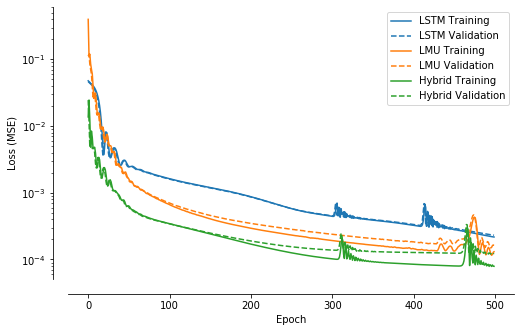

In [18]:
colors = sns.color_palette(None, 3)

plt.figure(figsize=(8, 5))
plt.plot(lstm_history.history['loss'], c=colors[0], label="LSTM Training")
plt.plot(lstm_history.history['val_loss'], c=colors[0], label="LSTM Validation", linestyle='--')

plt.plot(lmu_history.history['loss'], c=colors[1], label="LMU Training")
plt.plot(lmu_history.history['val_loss'], c=colors[1], label="LMU Validation", linestyle='--')

plt.plot(hybrid_history.history['loss'], c=colors[2], label="Hybrid Training")
plt.plot(hybrid_history.history['val_loss'], c=colors[2], label="Hybrid Validation", linestyle='--')

plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.yscale('log')
plt.legend()

sns.despine(offset=15)

plt.show()

In [20]:
print(lstm_time, lmu_time, hybrid_time)

20.3430646276474 12.889788649082185 16.20919619178772


In [21]:
lstm_Y = lstm_model.predict(test_X)
lmu_Y = lmu_model.predict(test_X)
hybrid_Y = hybrid_model.predict(test_X)

In [22]:
assert train_Y.shape[-1] == test_Y.shape[-1] == 1
print("LSTM", mean_squared_error(lstm_Y[:, :, 0], test_Y[:, :, 0]))
print("LMU", mean_squared_error(lmu_Y[:, :, 0], test_Y[:, :, 0]))
print("Hybrid", mean_squared_error(hybrid_Y[:, :, 0], test_Y[:, :, 0]))

LSTM 0.00029430085647073694
LMU 0.0001380439872248116
Hybrid 0.00011902449916338007


In [25]:
from pandas import DataFrame
from collections import defaultdict
from nengolib.signal import nrmse

e_label = r'$\left(\hat{y}(t) - y(t)\right)^2$'

errors = defaultdict(list)
for name, pred_Y in (("LSTM", lstm_Y),
                     ("LMU", lmu_Y),
                     ("Hybrid", hybrid_Y),
                     ("Baseline", test_X)):
    print(name, "%.3f" % (100*nrmse(pred_Y.flatten(), target=test_Y.flatten())))
    
    for i in range(test_Y.shape[0]):
        for j in range(test_Y.shape[1]):
            errors[e_label].append((pred_Y[i, j, 0] - test_Y[i, j, 0])**2)
            errors['Time-step'].append(i)
            errors['Test'].append(j)
            errors['Method'].append(name)

LSTM 7.940
LMU 5.438
Hybrid 5.049
Baseline 162.274


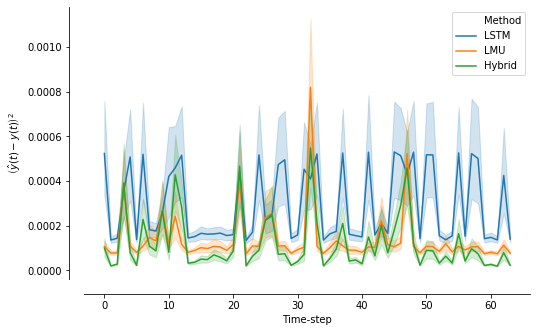

In [24]:
plt.figure(figsize=(8, 5))
sns.lineplot(data=DataFrame(errors), x="Time-step", y=e_label, hue="Method")
#plt.xscale('log')
#plt.yscale('log')
sns.despine(offset=15)

plt.show()